In [70]:
#Some installations will be needed in order to run this code

import numpy as np
import matplotlib.pyplot as plt
#from geopy.distance import great_circle

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #Package for handling geospatial data
from shapely import wkt  #The geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)

# # Pre-pre-processing (only do the following once, they do take some time)

First we read all the CSV-files into a Panda dataframes (df) - we later combine all the data into one df!

This takes about 5-10 minutes - Jupiter works so that once you've run a cell you don't have to run it again!

In [ ]:
#if you only want to use one dataset/run some testing ignore the below cell and run this instead:


#test_set = 100 #only use 100 edges

#df = pd.read_csv(r"Stadradeln_Movebis/geschwindigkeiten_2020.csv", sep=",")

#n_rows = df.shape[0] #get last index
#df = df.drop(df.index[test_set:n_rows]) #delete all rows after "test_set" 

In [300]:
#Read data into panda

df_2018 = pd.read_csv(
    r"Stadradeln_Movebis/geschwindigkeiten_2018.csv",
    sep=",")

df_2019 = pd.read_csv(
    r"Stadradeln_Movebis/geschwindigkeiten_2019.csv",
    sep=",")

df_2020 = pd.read_csv(
    r"Stadradeln_Movebis/geschwindigkeiten_2020.csv",
    sep=",")


This is where we should put any cuts we know we want to make into the code, to save time!

In [ ]:
df = pd.concat([df_2018, df_2019,df_2020], ignore_index=True, sort=False) #put all years in the same dataframe

In [305]:
# Initial check on number of rows and columns
n_rows = df.shape[0]
n_columns = df.shape[1]
print(f"Number of rows: {n_rows}\nNumber of columns: {n_columns}")

Number of rows: 65718874
Number of columns: 3


Below we use the GeoPandas dataframe (gdf) to process the geo-data;

We rename "edge_geo" to "geometry" (not necessary - simple convention);

We inform Panda that "geometry" contains geo-spacial data (using shapely/wtk);

We create a geospatial dataframe gdf containing only the geometry, and
use GeoPandas length-function to create a new column (containing length)

We then return that column to our original dataframe.

This takes about 30+ minutes (if all three data-sets are being used), so be warned!

In [307]:
df.rename(columns = {'edge_geo':'geometry'}, inplace = True) #simple naming convention

df["geometry"] = gpd.GeoSeries.from_wkt(df["geometry"])      #Tell panda that the "geometry" is geo-data in wkt-format
gdf = gpd.GeoDataFrame(df["geometry"], geometry='geometry')  #Create geospatial dataframe in geopanda

#Add a new column to gdf that contains the length of each line-segment
R_earth = 6371*1000   # earth radius [m]
d2r = np.pi/180
gdf["length"] = gdf["geometry"].length * d2r * R_earth

#Steal that column back for your original df
df["length"] = gdf["length"]

#print(gdf.head()) #Look at the data

#This has a (rare) tendency to return the error: "Expected bytes or string, got LineString"
#This seem to happen if the panda df has been meddled with too much
#Simply reload the df (start over) and it should work

                                            geometry     length
0  LINESTRING (13.33734 49.06005, 13.33812 49.05981)  91.366416
1  LINESTRING (13.33812 49.05981, 13.33734 49.06005)  91.366416
2  LINESTRING (13.33652 49.06022, 13.33574 49.06030)  87.137119
3  LINESTRING (13.33574 49.06030, 13.33652 49.06022)  87.137119
4  LINESTRING (13.33652 49.06022, 13.33683 49.06017)  34.239417


Below we do some final touches to or dataframe;

- Convert km/h into m/s (and rename the column)
- Add "duration"-column (length/speed)
- Add "total_duration"-column (duration*visitors)

In [308]:
#change km/h into m/s:
df["avg_speed_kmh"] = df["avg_speed_kmh"]/3.6               
df.rename(columns = {'avg_speed_kmh':'av_speed_ms'}, inplace = True)

#Add duration column to df
df["duration"] = df["length"]/df["av_speed_ms"]

#Add total_duration 
df["total_duration"] = df["duration"]*df["visits"]

This would be the time to clean up the data a little bit. Things such as

- potential NaN-values,
- really long/short edges,
- infeasible velocities,
- etc

No such thing is included as of yet.

In [309]:
#Potential clean up code goes here

## End of pre-pre-processing
The cells ABOVE this point should (for your own sake) only be run once. 
The cells below can be altered to your hearts content! 

Maybe add a save here? 

In [ ]:
#SAVE
#df.to_csv("all_three.csv", index=False)

# # Start from here next time :)
(don't forget to run/import the first cell)

In [ ]:
#Read saved 
#df = pd.read_csv(r"all_three.csv")

#remove bin column (this is just for me personally because on the version I saved I had 
#already done one aggregation, so just a reminder to remove that one)

#df = data.drop(["Average speed [m/s]"], axis = 1, inplace = True)

We also want to set our bin-sizes, which is done below. All data and assignment into bins are done in m/s but for legibility the finals bins are denoted with km/h. This could of course change if we decide to bin another way, but I wanted to stick to the current convention, as for now.

In [310]:
#Here we simply set the bin-sizes for the average speed
variable = "av_speed_ms"  
grouped_variable_name = "Average speed [m/s]"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,51):
    bin_edges.append(i/3.6)
bin_edges.append(np.inf)

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,51):
    bin_labels.append(str(k))

bin_labels.append("> " + str(k))


#bin_edges = [-np.inf,0.5, 1, 1.5, 2,3,4, 15, np.inf]
#bin_labels = ["<0.5","0.5-1", "1-1.5", "1.5-2", "2-3", "3-4", "4-15", ">15"]


# This part does the grouping based on the input above
df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e. a row is now given by: edge(geometry, duration, visitors, speed_BIN)

In [311]:
#run cell to look at the final data-frame (will only print out first and last five lines, so don't be scared)
df

,geometry,av_speed_ms,visits,length,duration,total_duration,Average speed [m/s]
0,"LINESTRING (13.33734 49.06005, 13.33812 49.05981)",2.268807,1,91.366416,40.270690,40.270690,9
1,"LINESTRING (13.33812 49.05981, 13.33734 49.06005)",6.184439,1,91.366416,14.773598,14.773598,23
2,"LINESTRING (13.33652 49.06022, 13.33574 49.06030)",8.091433,1,87.137119,10.769058,10.769058,30
3,"LINESTRING (13.33574 49.06030, 13.33652 49.06022)",2.482184,1,87.137119,35.105026,35.105026,9
4,"LINESTRING (13.33652 49.06022, 13.33683 49.06017)",2.397976,1,34.239417,14.278463,14.278463,9
...,...,...,...,...,...,...,...
65718869,"LINESTRING (8.38740 55.03568, 8.38775 55.03568)",7.431055,3,39.642902,5.334761,16.004284,27
65718870,"LINESTRING (8.38775 55.03568, 8.38740 55.03568)",5.507002,9,39.642902,7.198636,64.787721,20
65718871,"LINESTRING (8.38797 55.03570, 8.38815 55.03573)",6.912990,3,20.167661,2.917357,8.752072,25
65718872,"LINESTRING (8.38815 55.03573, 8.38797 55.03570)",5.452114,9,20.167661,3.699053,33.291478,20


Now we have the data, but how to use it?

There are some things of interest.

Below are some ways of "counting" the occurances. 
For easy comparison a row will be referred to as an edge containing the following information:

    edge(geometry, duration, visitors, speed)

since "geometry" is not used it will instead be used as an ID for identifying each separate column 
(this is arbitrary, since any column could be used for this but I made a choice :))

In [312]:
#Which one do we want to look at? 
#In the future cuts of this size should be decided on higher up in the code, to speed up computations

df_ones = df.loc[df["visits"]==1]
#df_low = df.loc[df["visits"] <= 10]
df_high = df.loc[df["visits"]>=10]

df_ = df_high #Assign which data to plot

In [277]:
#We can aggregate the data in different ways
aggregations = {
    "geometry": "count",  #"geometry" is used here to calculate how many rows of data are in each category
    "duration": "sum", #If we want to aggregate based on duration
    "visits": "sum", #If we want to aggregate based on visits
    "total_duration": "sum", #if we want to aggregate based on visitis*duration
}

# Renaming of "geometry" in aggregation since it is only (arbitrarily) used for counting the number of rows
renamings = {"geometry": "NumberOfRows"}

# Do the aggregation and renamning
df_agg_stat = (
    df_.groupby(grouped_variable_name).agg(aggregations).rename(columns=renamings)
)

# Display the aggregated data
#print(df_agg_stat)

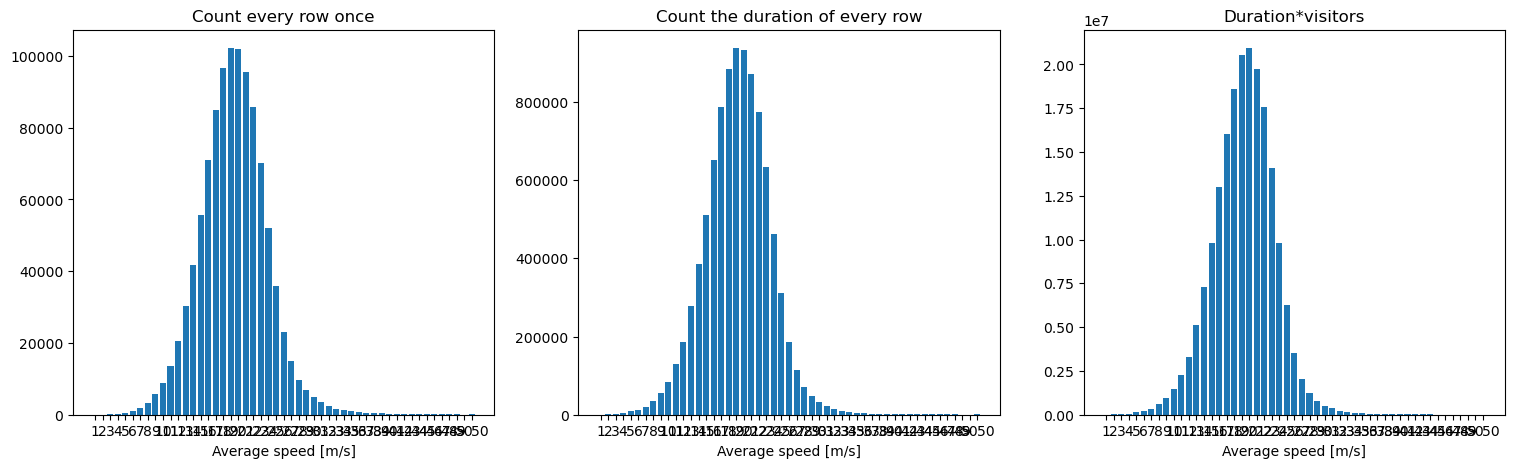

In [272]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfRows"])
plt.title("Count every row once")


plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["duration"])
plt.title("Count the duration of every row")


plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["total_duration"])
plt.title("Duration*Visitors")

plt.show()

Below we plot again for the single visits

In [273]:
df_ = df_ones

In [275]:
#We can aggregate the data in different ways
aggregations = {
    "geometry": "count",  #"geometry" is used here to calculate how many rows of data are in each category
    "duration": "sum", #If we want to aggregate based on duration
    "visits": "sum", #If we want to aggregate based on visits
    "dur_vis": "sum",
}

# Renaming of "geometry" in aggregation since it is only (arbitrarily) used for counting the number of rows
renamings = {"geometry": "NumberOfRows"}

# Do the aggregation and renamning
df_agg_stat = (
    df_.groupby(grouped_variable_name).agg(aggregations).rename(columns=renamings)
)

# Display the aggregated data
#print(df_agg_stat)

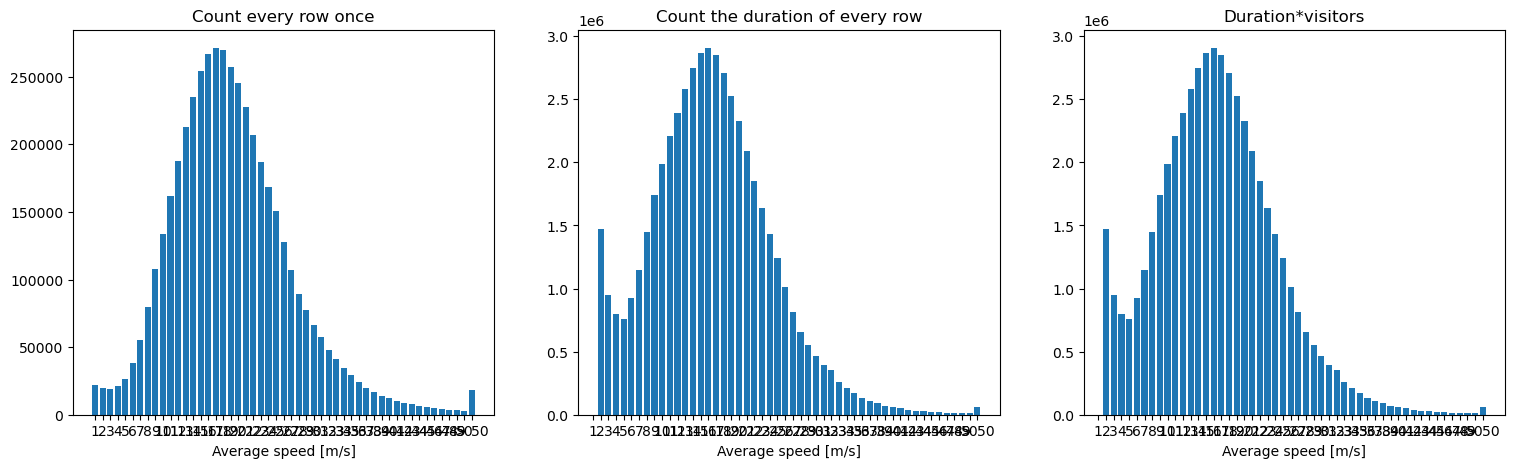

In [276]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfRows"])
plt.title("Count every row once")


plt.subplot(142)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["duration"])
plt.title("Count the duration of every row")


plt.subplot(143)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["dur_vis"])
plt.title("Duration*visitors")

plt.show()

Some other interesting data

- how long the edges are
- how length of edge relate to average velocity
- how number of visitors affect deviance from the mean?

In [ ]:
#maximum and minimum length of edges
print(max(df["length"]))
print(min(df["length"]))

In [288]:
#Make a histogram based on lengths of edges
variable = "length"  
grouped_variable_name = "Length"

bin_edges = [-np.inf,20, 40, 60, 80,100,200, 500, np.inf]
bin_labels = ["<20","20-40", "40-60", "60-80", "80-100", "100-200", "200-500", ">500"]

# This part does the grouping based on the input above
df[grouped_variable_name] = pd.cut(
    df[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

aggregations = {
    "geometry": "count",  #"geometry" is used here to calculate how many rows of data are in each category
}

# Renaming of "geometry" in aggregation since it is only (arbitrarily) used for counting the number of rows
renamings = {"geometry": "NumberOfRows"}

# Do the aggregation and renamning
df_agg_stat = (
    df.groupby(grouped_variable_name).agg(aggregations).rename(columns=renamings)
)

# Display the aggregated data
#print(df_agg_stat)

fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat.index.name)
plt.bar(df_agg_stat.index, df_agg_stat["NumberOfRows"])
plt.title("Length of edges")